In [1]:
from lib.opt_types import *
from lib.utils import *
from lib.part_one import f, f_full_data, x_zero

# Stochastic gradient methods - 30 Points


In this problem, you will implement three different versions of stochastic gradient descent to solve the logistic regression problem on the entire NBA dataset.

In order to use the stochastic gradient descent methods, we recast our estimation problem (3) as follows,

$$
f(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^n\bigg\{\underbrace{\log(1 + \exp(- b_i \mathbf{a}_i^T\mathbf{x})) + \frac{\mu}{2}\|\mathbf{x}\|^2}_{f_i(\mathbf{x})}\bigg\},
$$

where we for notational convenience suppress the dependency on $\mu$.
As we saw in Problem 1, we have that

$$
\nabla f_i(\mathbf{x}) = -b_i \sigma(-b_i \cdot \mathbf{a}_i^T\mathbf{x})\mathbf{a}_i + \mu \mathbf{x}.
$$

The objective function can be written as a sum of $n$ terms. We augment the `Function` type introduced in previous notebooks to include the following attributes:

- To access the gradient of the `j`-th term at a point `x` you can write `f.i_grad(j, x)`.
- The number of terms $n$ is stored in the attribute `f.n`. 

Consider the following stochastic gradient update: At the iteration $k$, pick $i_k\in\{1, \ldots, n\}$ uniformly at random and define

$$
\mathbf{x}^{k+1} :=  \mathbf{x}^k - \alpha_k\nabla{f}_{i_k}(\mathbf{x}^k).
$$

__(a)__ (2 points) Show that $\nabla f_{i_k}(\mathbf{x})$ is an unbiased estimation of $\nabla f(\mathbf{x})$. Explain why $\nabla f_{i_k}$ is Lipschitz continuous with $L(f_{i_k}) = \|\mathbf{a}_{i_k}\|^2+ \mu $. 

__Hint__: Recall how we computed $L$ in Problem 1. In the following, we will set $L_{\max} = \max_{i\in\{1, \ldots, n\}}L(f_i)$.

### Unbiasedness
At iteration $k$, the index $i_k$ is drawn uniformly from $\{1,\ldots,n\}$.  
Therefore,

$$
\mathbb{E}[\nabla f_{i_k}(\mathbf{x})]
= \frac{1}{n}\sum_{i=1}^n \nabla f_i(\mathbf{x})
= \nabla \left(\frac{1}{n}\sum_{i=1}^n f_i(\mathbf{x})\right)
= \nabla f(\mathbf{x}).
$$

Hence, $\nabla f_{i_k}(\mathbf{x})$ is an unbiased estimator of $\nabla f(\mathbf{x})$.



### Lipschitz continuity
For a fixed $i$, recall

$$
\nabla f_i(\mathbf{x}) = -b_i \, \sigma(-b_i \mathbf{a}_i^\top \mathbf{x}) \, \mathbf{a}_i + \mu \mathbf{x},
$$

where $\sigma(t) = \frac{1}{1+e^{-t}}$ is the sigmoid function.  

For $\mathbf{x},\mathbf{y}\in\mathbb{R}^d$, let  
$z_x = -b_i \mathbf{a}_i^\top \mathbf{x}$ and $z_y = -b_i \mathbf{a}_i^\top \mathbf{y}$. Then

$$
\begin{aligned}
\|\nabla f_i(\mathbf{x}) - \nabla f_i(\mathbf{y})\|
&= \Big\| -b_i \big(\sigma(z_x) - \sigma(z_y)\big)\mathbf{a}_i + \mu(\mathbf{x}-\mathbf{y}) \Big\| \\
&\leq |\sigma(z_x) - \sigma(z_y)| \, \|\mathbf{a}_i\| + \mu \|\mathbf{x}-\mathbf{y}\|.
\end{aligned}
$$

Since the sigmoid function $\sigma$ is 1-Lipschitz,

$$
|\sigma(z_x) - \sigma(z_y)| \leq |z_x - z_y|.
$$

We have that,

$$
|z_x - z_y| = \big| -b_i \mathbf{a}_i^\top (\mathbf{x}-\mathbf{y}) \big|
\leq \|\mathbf{a}_i\| \, \|\mathbf{x}-\mathbf{y}\|.
$$

Then,

$$
|\sigma(z_x) - \sigma(z_y)| \leq \|\mathbf{a}_i\| \, \|\mathbf{x}-\mathbf{y}\|.
$$

We put this into the difference of gradients

$$
\|\nabla f_i(\mathbf{x}) - \nabla f_i(\mathbf{y})\|
\leq \big(\|\mathbf{a}_i\|^2 + \mu\big)\|\mathbf{x}-\mathbf{y}\|.
$$

Therefore by the definition of a K-Lipschitz funtion, $\nabla f_i$ is Lipschitz continuous with constant
$$
L(f_i) = \|\mathbf{a}_i\|^2 + \mu,
$$

and consequently

$$
L_{\max} = \max_{i\in\{1,\dots,n\}} L(f_i) = \max_{i\in\{1,\dots,n\}} \big(\|\mathbf{a}_i\|^2 + \mu\big).
$$

__(b)__ (2 points) 
We can use the standard stochastic gradient descent method SGD to solve the problem above.
Implement `SGD` by completing the following cells with $\alpha_k =\frac{0.01}{k}$.

**Hint**: For some `N`, the function `np.random.choice(N)` generates a random integer in $\{0, \dots, N-1 \}$.


In [2]:
@dataclass
class SGD_state(OptState):
    x_k: Vector
    k: int

In [ ]:
def SGD_update(f, state):
    x_k, k = state.x_k, state.k

    
    i_k = np.random.choice(f.n)

    
    alpha_k = 0.01 / k

    
    next_x_k = x_k - alpha_k * f.i_grad(i_k, x_k)

    return SGD_state(next_x_k, k + 1)

def SGD_initialize(f, x_zero):
    return SGD_state(x_zero, 1.0)

In [9]:
SGD = OptAlgorithm(name="SGD", init_state=SGD_initialize, state_update=SGD_update)

__(c)__ (6 points) 
Consider the following stochastic averaging gradient method SAG to solve the problem above:

$$
\begin{aligned}
&\text{pick } i_k\in\{1, \ldots, n\} \text{ uniformly at random}\\
&\mathbf{x}^{k+1} := \mathbf{x}^k - \frac{\alpha_k}{n}\sum_{i=1}^n\mathbf{v}_i^k,
\end{aligned}
$$

where 

$$
\mathbf{v}_i^k =
\begin{cases}
\nabla f_i(\mathbf{x}^k) &\text{if}\, i = i_k,\\
\mathbf{v}_i^{k-1} &\text{otherwise}.
\end{cases}
$$

Implement `SAG` by completing the following cells using the step-size 
$\alpha_k=\frac{0.01}{L_{\max}}$ and $\mathbf{v}^0=\mathbf{0}$. (Note that you can access $L_{\max}$ by writing `f.L_max`. 

In [14]:
@dataclass
class SAG_state(OptState):
    x_k: Vector
    v_k: List[Vector]
    alpha_k: float

In [18]:
def SAG_update(f, state):

    x_k, v_k, alpha_k = state.x_k, state.v_k, state.alpha_k


    i_k = np.random.choice(f.n)

        
    v_k = list(v_k)  
    v_k[i_k] = f.i_grad(i_k, x_k)

        
    grad_sum = np.add.reduce(v_k) 
    next_x_k = x_k - (alpha_k / f.n) * grad_sum

    return SAG_state(next_x_k, v_k, alpha_k)

def SAG_initialize(f, x_zero):
    alpha_k = 0.01 / f.L_max
    v0 = [np.zeros_like(x_zero) for _ in range(f.n)]
    return SAG_state(x_zero, v0, alpha_k)

In [19]:
SAG = OptAlgorithm(name="SAG", init_state=SAG_initialize, state_update=SAG_update)

SAG    : 100%|██████████| 500000/500000 [10:47<00:00, 771.70it/s] 


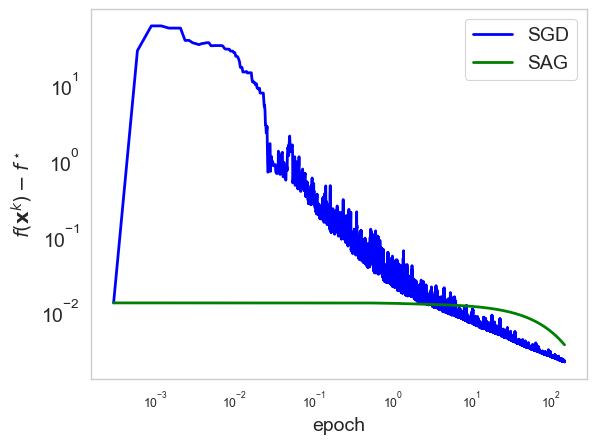

In [20]:
plot_epochs([SGD, SAG], f, x_zero, 500000)

__(d)__ (6 points) 
We can improve the convergence rate of SGD by periodically computing the full gradient. `SVRG` uses the following variance reduction scheme:

$$
\begin{aligned}
&\text{if } k = 0 \text{ mod } q:\\
&\quad \mathbf{z} = \mathbf{x}^k\\
&\quad \tilde{\mathbf{v}} = \nabla f(\mathbf{x}^k)\\
&\text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
&\mathbf{d}^k = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}(\mathbf{z}) + \tilde{\mathbf{v}}\\
&{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma\mathbf{d}^k
\end{aligned}
$$

Implement `SVRG` by completing the following cells and fixing the following constant:
$\gamma = 1/L_{\max}$ and $q = 100$. 

In [28]:
@dataclass
class SVRG_state(OptState):
    x_k: Vector 
    z: Vector
    tilde_v: Vector
    q: int
    gamma: float
    k: int

In [ ]:
def SVRG_update(f, state):
    x_k, z, tilde_v, q, gamma, k = (
        state.x_k, state.z, state.tilde_v, state.q, state.gamma, state.k
    )

    # Snapshot every q iterations
    if k % q == 0:
        z = x_k.copy()
        tilde_v = f.grad(z)          # full gradient at snapshot point


    i_k = np.random.choice(f.n)

    
    d_k = f.i_grad(i_k, x_k) - f.i_grad(i_k, z) + tilde_v


    x_next = x_k - gamma * d_k

    return SVRG_state(x_next, z, tilde_v, q, gamma, k + 1)


def SVRG_initialize(f, x_zero):
    gamma = 1.0 / f.L_max
    q = 100
    z0 = x_zero.copy()
    tilde_v0 = np.zeros_like(x_zero)  # will be set on first update (k = 0 mod q)
    return SVRG_state(x_zero, z0, tilde_v0, q, gamma, 0)

In [30]:
SVRG = OptAlgorithm(name="SVRG", init_state=SVRG_initialize, state_update=SVRG_update)

__(e)__ (8 points) Another variance reduction method is `SARAH`. The scheme can be described as follows:

$$
\begin{aligned}
&\text{if } k = 0 \text{ mod } q:\\
&\quad {\mathbf{x}}^k = {\mathbf{z}}\\
&\quad {\mathbf{v}}^k = \nabla f({\mathbf{z}})\\
&\quad t \in \{0, \ldots, q-1\} \text{ uniformly at random}\\
&\text{if } k = t \text{ mod } q:\\
&\quad {\mathbf{z}} = {\mathbf{x}}^{k}\\
&\text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
&{\mathbf{v}}^{k+1} = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}({\mathbf{x}^{k-1}}) + {\mathbf{v}}^{k}\\
&{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma {\mathbf{v}}^{k+1}
\end{aligned}
$$


Implement `SARAH` by completing the following cells. Pick `q=100` and $\gamma = \frac{1}{L_{\max}}$.

In [31]:
@dataclass
class SARAH_state(OptState):
    x_k: Vector 
    prev_x_k: Vector
    v_k: Vector
    z: Vector
    q: int
    t: int
    gamma: float
    k: int

In [ ]:
def SARAH_update(f, state):
    x_k      = state.x_k
    prev_x_k = state.prev_x_k
    v_k      = state.v_k
    z        = state.z
    q        = state.q
    t        = state.t
    gamma    = state.gamma
    k        = state.k
# snapshot and pick a fresh t
    if k % q == 0:
        x_k = z.copy()
        v_k = f.grad(z)                 
        t   = np.random.randint(q)      

    # If k ≡ t (mod q), refresh z
    if k % q == t:
        z = x_k.copy()

    i_k = np.random.choice(f.n)
    v_next = f.i_grad(i_k, x_k) - f.i_grad(i_k, prev_x_k) + v_k

  
    x_next = x_k - gamma * v_next


    return SARAH_state(
        x_k=x_next,
        prev_x_k=x_k,
        v_k=v_next,
        z=z,
        q=q,
        t=t,
        gamma=gamma,
        k=k + 1
    )

def SARAH_initialize(f, x_zero):
    q = 100
    gamma = 1.0 / f.L_max
    return SARAH_state(
        x_k=x_zero,
        prev_x_k=x_zero,                 # used for the first recursive difference
        v_k=np.zeros_like(x_zero),       # will be set at k=0 (mod q)
        z=x_zero.copy(),                 
        q=q,
        t=0,                             
        gamma=gamma,
        k=0                           
    )

In [39]:
SARAH = OptAlgorithm(name="SARAH", init_state=SARAH_initialize, state_update=SARAH_update)

__(f)__ (6 points) Another variance reduction method is `Spider`. The scheme can be described as follows:

$$
\begin{aligned}
&\text{if } k = 0 \text{ mod } q:\\
&\quad {\mathbf{v}}^k = \nabla f({\mathbf{x}}^k)\\
&\text{if } k \neq 0 \text{ mod } q:\\
&\quad \text{Pick } i_k\in \{1, \ldots, n\} \text{ uniformly at random}\\
&\quad {\mathbf{v}}^k = \nabla f_{i_k}({\mathbf{x}}^k) - \nabla f_{i_k}({\mathbf{x}}^{k-1}) + {\mathbf{v}}^{k-1}\\
&\eta := \min \big(\frac{1}{\left \| {\mathbf{v}}^{k} \right \|_2}, \frac{1}{\epsilon}\big)\\
&{\mathbf{x}}^{k+1} := {\mathbf{x}}^k - \gamma \eta {\mathbf{v}}^{k}
\end{aligned}
$$


Implement `Spider` by completing the following cells. Pick `q=100`, $\epsilon = 0.05$ and $\gamma = \frac{1}{L_{\max}}$.

In [40]:
@dataclass
class Spider_state(OptState):
    x_k: Vector 
    prev_x_k: Vector
    prev_v_k: Vector
    q: int
    gamma: float
    k: int
    epsilon: float

In [ ]:
import numpy
from numpy.linalg import norm

def Spider_update(f, state):
    x_k      = state.x_k
    prev_x_k = state.prev_x_k
    prev_v_k = state.prev_v_k
    q        = state.q
    gamma    = state.gamma
    k        = state.k
    eps      = state.epsilon

    # v^k
    if k % q == 0:
        v_k = f.grad(x_k)  
    else:
        i_k = np.random.choice(f.n)
        v_k = f.i_grad(i_k, x_k) - f.i_grad(i_k, prev_x_k) + prev_v_k

    
    vnorm = norm(v_k)
    eta = min((1.0 / vnorm) if vnorm > 0 else np.inf, 1.0 / eps)

    
    x_next = x_k - gamma * eta * v_k

  
    return Spider_state(
        x_k=x_next,
        prev_x_k=x_k,
        prev_v_k=v_k,
        q=q,
        gamma=gamma,
        k=k + 1,
        epsilon=eps,
    )

def Spider_initialize(f, x_zero):
    q = 100
    gamma = 1.0 / f.L_max
    epsilon = 0.05
    return Spider_state(
        x_k=x_zero,
        prev_x_k=x_zero,                 # used for the k=1 
        prev_v_k=np.zeros_like(x_zero),  # will be overwritten at k=0 
        q=q,
        gamma=gamma,
        k=0,                             #  k % q == 0 triggers a snapshot
        epsilon=epsilon,
    )

In [42]:
Spider = OptAlgorithm(name="Spider", init_state=Spider_initialize, state_update=Spider_update)

Spider : 100%|██████████| 50000/50000 [01:34<00:00, 528.06it/s]


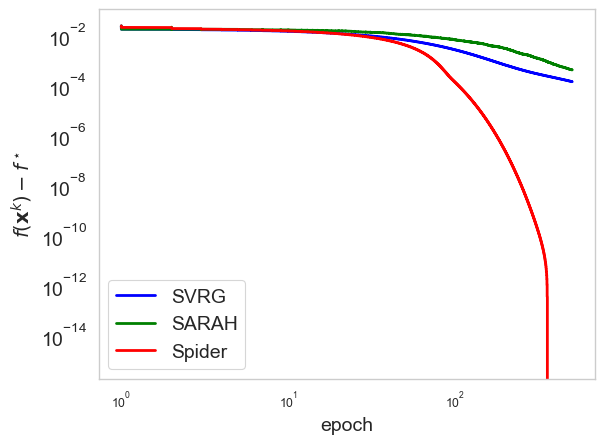

In [43]:
plot_epochs([SVRG, SARAH, Spider], f_full_data, x_zero, 50000)